In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import filter_utils as filt

In [3]:
data_dir = "./data/"
data_fn = data_dir + "cleaned_data.txt"
data_grey_fn = data_dir + "cleaned_grey_values.txt"

In [4]:
all_elements = pd.read_csv(data_fn)
print(all_elements.head())

   Distance (um)  Elapsed Time   B11_ppm  Na23_ppm  Mg25_ppm  Al27_ppm  \
0      -1.483983     -1.483983 -0.000987 -1.739987  1.252779 -1.428722   
1      -1.478071     -1.478071  0.273978 -0.963147  2.358353 -1.189735   
2      -1.472164     -1.472164 -0.041514 -1.274842  1.587131 -0.879393   
3      -1.466252     -1.466252  0.646814 -0.961113  1.437627 -1.582681   
4      -1.460344     -1.460344  0.151465 -1.214546  1.474992 -1.570397   

   Si28_ppm   P31_ppm   S34_ppm  Cl35_ppm  ...  Zn66_ppm  Zn68_ppm  Sr88_ppm  \
0 -1.030042  1.095407  0.576121 -1.078462  ...  1.409131  1.572304  1.231484   
1 -0.483173  1.588047  1.585102 -1.104329  ...  1.439062  1.372410  0.979279   
2 -0.694485  1.389658  0.317097 -0.880657  ...  1.674240  1.736563  0.941318   
3 -1.052700  1.525399 -0.236500 -1.136729  ...  1.628649  1.488895 -0.189878   
4 -1.296695  1.237596 -0.067184 -1.486543  ...  1.335298  1.297910  0.958900   

   Ba138_ppm  PbTotal_ppm     pixel  new_distance  new_pixel  case  sex  


In [5]:
grey_values = pd.read_csv(data_grey_fn)
print(grey_values)

      Distance_(pixels)  Gray_Value  new_pixel  case  cleaned_grey sex
0                   432    126.7965          0    43      4.842583   M
1                   433    126.2878          1    43      4.838563   M
2                   434    123.3846          2    43      4.815306   M
3                   435    120.0393          3    43      4.787819   M
4                   436    118.5882          4    43      4.775657   M
...                 ...         ...        ...   ...           ...  ..
5678               1746    104.8251       1480    56      4.631919   F
5679               1747    104.6929       1481    56      4.631425   F
5680               1748    103.3024       1482    56      4.637661   F
5681               1749    101.6086       1483    56      4.621128   F
5682               1750    101.0000       1484    56      4.615121   F

[5683 rows x 6 columns]


In [6]:
elt_name = "S34_ppm" # "Sr88_ppm" # "Mg25_ppm" # "Cu65_ppm" # "Zn66_ppm" # 
elt_array = [
    all_elements[all_elements['case']==i][elt_name] for i in [43,44,55,56]
]
print([len(arr) for arr in elt_array])

[461, 320, 570, 711]


i=1, px=0.1500000111532847
i=2, px=0.127500009480292
i=3, px=0.10837500805824818
i=4, px=0.09211875684951096
i=5, px=0.07830094332208432
i=6, px=0.06655580182377167
i=7, px=0.056572431550205915
i=8, px=0.04808656681767502
i=9, px=0.040873581795023775
i=10, px=0.034742544525770205
i=11, px=0.02953116284690467
i=12, px=0.025101488419868968
i=13, px=0.021336265156888624
i=14, px=0.01813582538335533
i=15, px=0.01541545157585203
i=16, px=0.013103133839474226
i=17, px=0.011137663763553091
i=18, px=0.009467014199020128
i=19, px=0.008046962069167109
i=20, px=0.006839917758792042
i=21, px=0.005813930094973235
i=22, px=0.00494184058072725
i=23, px=0.004200564493618162
i=24, px=0.003570479819575438
i=25, px=0.003034907846639122
i=26, px=0.002579671669643254
i=27, px=0.002192720919196766
i=28, px=0.0018638127813172508
i=29, px=0.0015842408641196632
i=30, px=0.0013466047345017137
i=31, px=0.0011446140243264566
i=32, px=0.0009729219206774881
i=33, px=0.0008269836325758648
i=34, px=0.0007029360876894

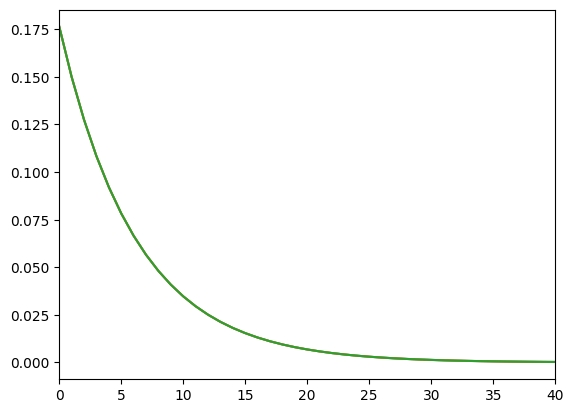

In [7]:
bandwidth = 100
mortality_rate = 0.15

def truncated_geometric_pdf(p: float, k: int, n: int = bandwidth) -> float:
    if k < 0 or n < 0:
        return 0.0
    return p * (1 - p)**(k-1) / (1 - (1 - p)**(n+1))

def prior1(x: np.ndarray, p: float = mortality_rate) -> np.ndarray:
    # Find the idx of the max True element.
    # This is the index of the highest frequency basis function included.
    # This is a proxy for age since age is the number of peaks and the 
    # highest frequency basis function has the most peaks of all basis functions.
    # (This is not a perfect proxy since a combination of lower frequency
    # basis functions can produce more peaks than a single high frequency)
    idx = -1
    for i in range(len(x)-1, -1, -1):
        if x[i]:
            idx = i
            break
    return truncated_geometric_pdf(p, i)

def prior2(x: np.ndarray, p: float = mortality_rate) -> np.ndarray:
    # Sum the frequencies of all basis functions.
    # This is a proxy for age since age is the number of peaks which is
    # at most the sum of all frequencies.
    s = 0
    for i in range(len(x)):
        s += i * x[i]
    return truncated_geometric_pdf(p, s)

# Assume that the mortality rate is 20% per year => p=0.8, prior prob of age s is 0.8^s.
def prior(x= np.ndarray, p=mortality_rate, q=0.9) -> np.ndarray:
    return prior1(x,p)*q + prior2(x,p)*(1-q)

xi = range(0, bandwidth+1)
xv = np.eye(bandwidth+1)
p1x = [prior1(xv[i]) for i in range(len(xv))]
p2x = [prior2(xv[i]) for i in range(len(xv))]
px = [prior(xv[i]) for i in range(len(xv))]
for i in range(1, len(px)):
    print(f"i={i}, px={px[i]}")
p = plt.figure()
p = plt.plot(xi, p1x, label="prior1")
p = plt.plot(xi, p2x, label="prior2")
p = plt.plot(xi, px, label="prior")
p = plt.xlim(0,40)
p = plt.show()

In [8]:
# threshold = filt.SUBSTANTIAL_DIFFERENCE_IN_MODELS_THRESHOLD # Substantial difference between models required to pick the more complex one.
threshold = filt.SIGNIFICANT_DIFFERENCE_IN_MODELS_THRESHOLD # Strong difference between models required to pick the more complex one.

In [9]:
criterion = "bic" # "aic" or "bic"
mode = "forward" # "forward" or "backward"

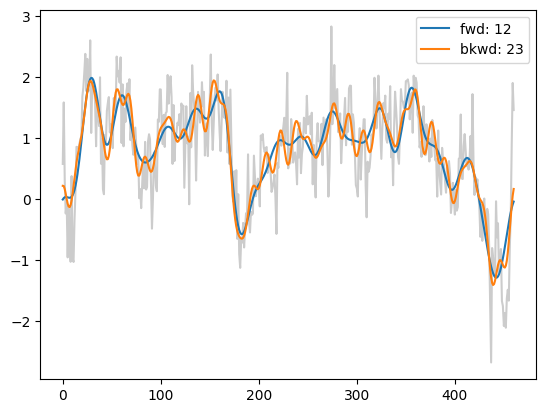

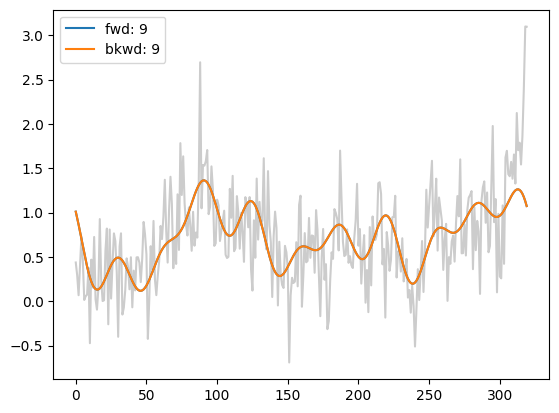

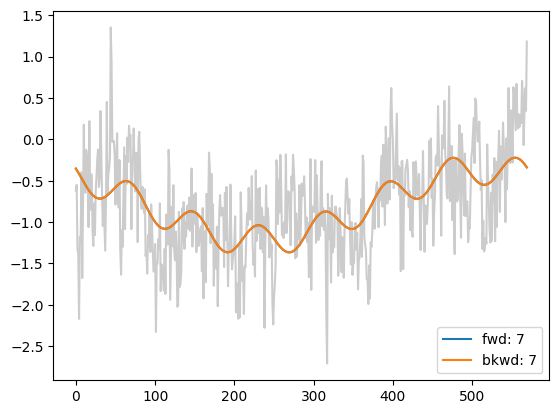

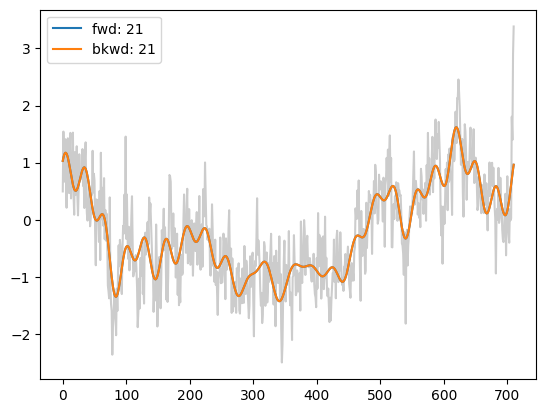

In [10]:
plts = []
fwd_yr_lens_array = []
bkwd_yr_lens_array = []
for i in range(len(elt_array)):
    elt = np.asarray(elt_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        elt, bandwidth, mode, threshold, criterion, prior
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        elt, bandwidth, "backward", threshold, criterion, prior
    )

    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

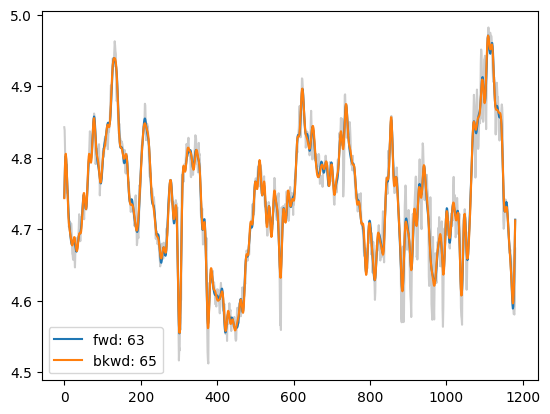

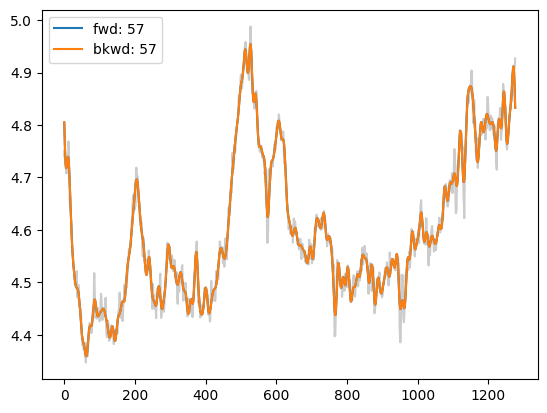

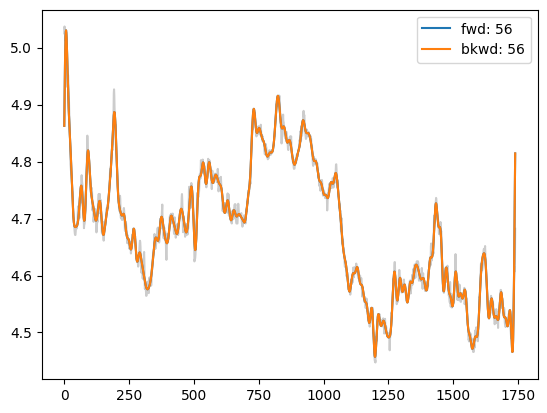

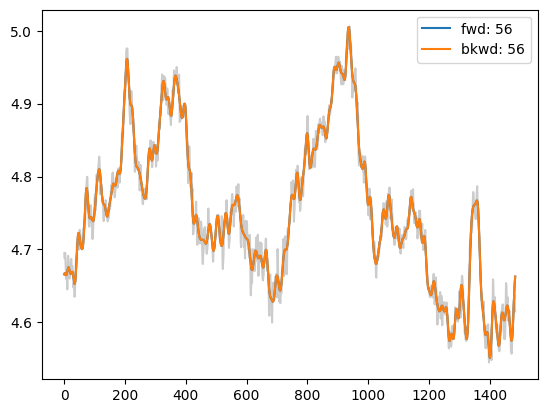

In [11]:
grey_array = [
    grey_values[grey_values['case']==i]['cleaned_grey'] for i in [43,44,55,56]
]
plts = []
for i in range(len(grey_array)):
    grey_val = np.asarray(grey_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "forward",
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "backward",
    )

    p = plt.figure()
    p = plt.plot(range(len(grey_val)), grey_val, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

In [12]:
(elt_array[0])

0      0.576121
1      1.585102
2      0.317097
3     -0.236500
4     -0.067184
         ...   
456   -0.822122
457   -0.262803
458    0.886909
459    1.904121
460    1.460023
Name: S34_ppm, Length: 461, dtype: float64

[1 2 3 4]
[1 2 3 4]
[[ 5.26059247e-01  5.26059247e-01 -2.91299921e-01 -2.05854006e-01
  -2.77415003e-02 -1.14765847e-03 -1.60818196e-05 -7.91168785e-08
  -1.38927859e-10  1.26006703e-17 -6.80753407e-18 -1.10502595e-17
  -7.40306796e-18 -2.19008839e-17  2.60208521e-17  5.55111512e-17]
 [ 5.41227819e-01  5.41227819e-01  2.02732303e-01 -1.46640430e-01
  -2.65319869e-01 -1.97269139e-01 -9.38523887e-02 -3.14873146e-02
  -7.74509134e-03 -1.42474431e-03 -1.98289869e-04 -2.10340241e-05
  -1.70910329e-06 -1.06749713e-07 -5.13844916e-09 -1.90984519e-10]
 [ 4.73689171e-01  4.73689171e-01  3.28250158e-01  1.09222015e-01
  -8.77027147e-02 -1.99142862e-01 -2.17700687e-01 -1.76219910e-01
  -1.15961566e-01 -6.43681216e-02 -3.07068664e-02 -1.27274401e-02
  -4.61538142e-03 -1.47126423e-03 -4.13682792e-04 -1.02855760e-04]
 [ 4.20320165e-01  4.20320165e-01  3.45091557e-01  2.16625270e-01
   7.00815023e-02 -5.93926457e-02 -1.47988239e-01 -1.88234986e-01
  -1.86983971e-01 -1.59000923e-01 -1.19979768e-01 -8.

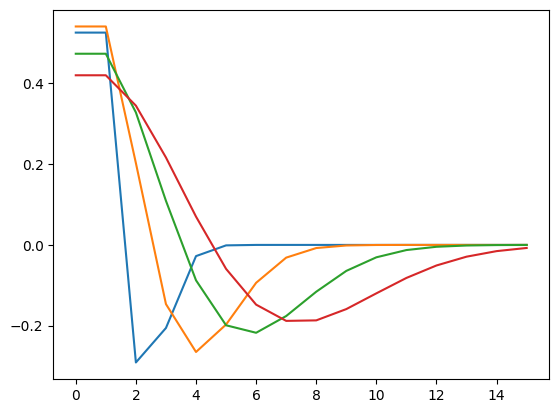

<Figure size 640x480 with 0 Axes>

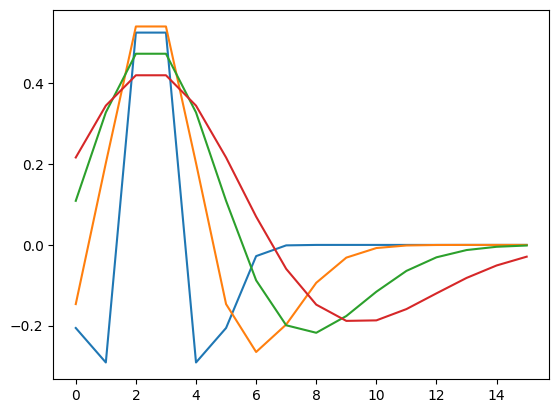

<Figure size 640x480 with 0 Axes>

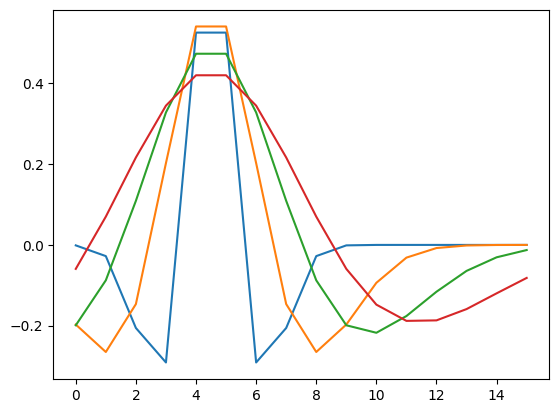

<Figure size 640x480 with 0 Axes>

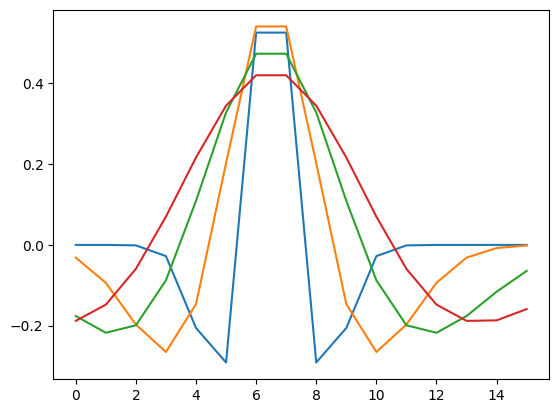

<Figure size 640x480 with 0 Axes>

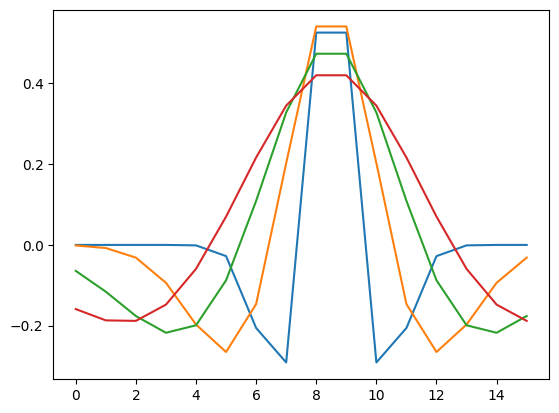

<Figure size 640x480 with 0 Axes>

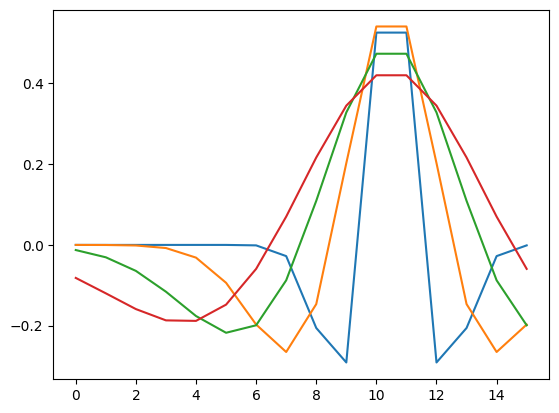

<Figure size 640x480 with 0 Axes>

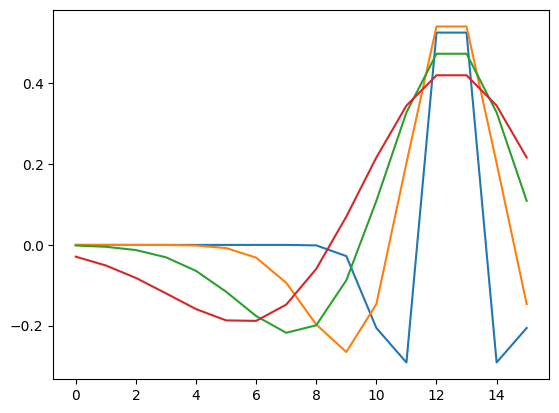

<Figure size 640x480 with 0 Axes>

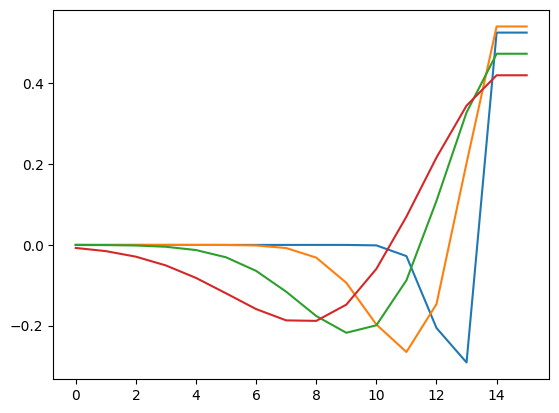

<Figure size 640x480 with 0 Axes>

[1 2 3 4]
[1 2 3 4]


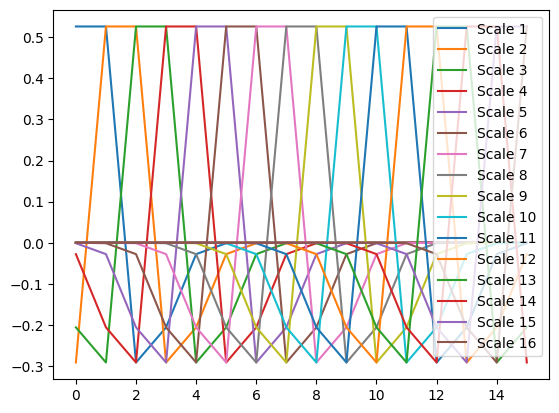

<Figure size 640x480 with 0 Axes>

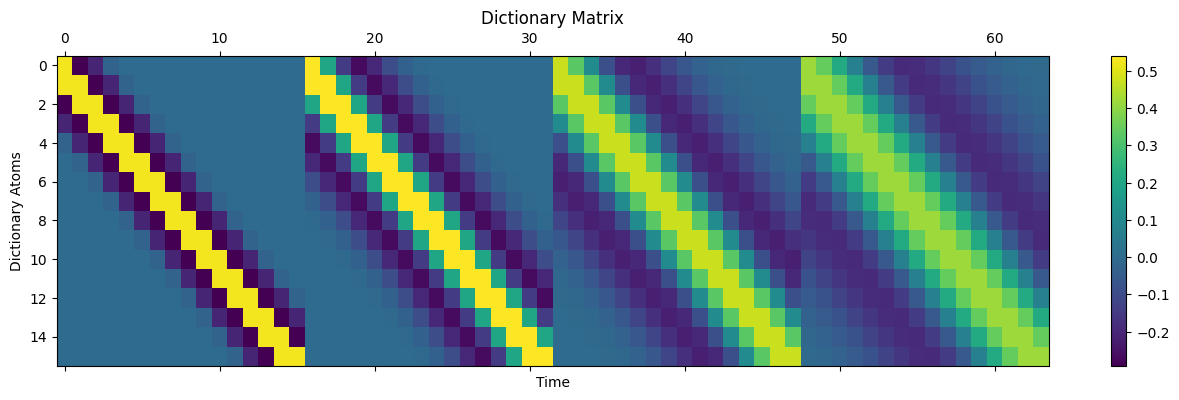

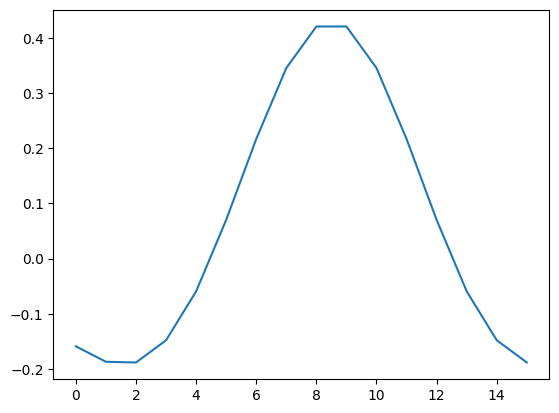

[[ 0.35355339  0.35355339  0.5         0.          0.70710678  0.
   0.          0.        ]
 [ 0.35355339  0.35355339  0.5         0.         -0.70710678  0.
   0.          0.        ]
 [ 0.35355339  0.35355339 -0.5         0.          0.          0.70710678
   0.          0.        ]
 [ 0.35355339  0.35355339 -0.5         0.          0.         -0.70710678
   0.          0.        ]
 [ 0.35355339 -0.35355339  0.          0.5         0.          0.
   0.70710678  0.        ]
 [ 0.35355339 -0.35355339  0.          0.5         0.          0.
  -0.70710678  0.        ]
 [ 0.35355339 -0.35355339  0.         -0.5         0.          0.
   0.          0.70710678]
 [ 0.35355339 -0.35355339  0.         -0.5         0.          0.
   0.         -0.70710678]]


In [13]:
import basis_pursiut_denoising as bpd

def get_wavelet_matrix(signal_length, wavelet, level):
    basis = []
    for i in range(signal_length):
        x = np.zeros(signal_length)
        x[i] = 1.0
        coeffs = bpd.pywt.wavedec(x, wavelet, mode='periodization', level=level)
        arr, _ = bpd.pywt.coeffs_to_array(coeffs)
        basis.append(arr)
    return np.array(basis)  # Columns are basis vectors

dictionary = get_wavelet_matrix(8, 'db1', int(np.log2(8)))
print(dictionary)



[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1181
41


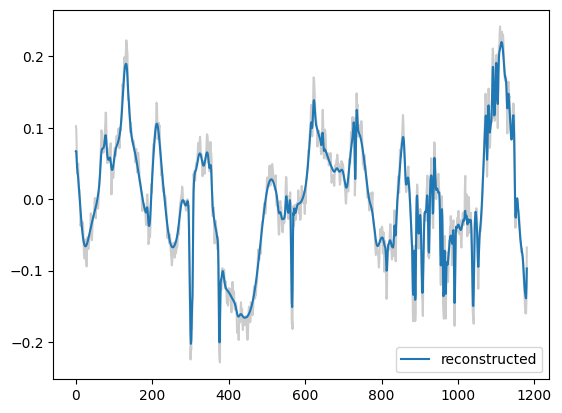

200


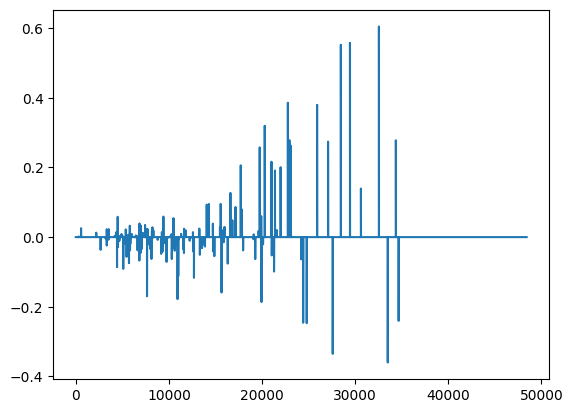

[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1277
42


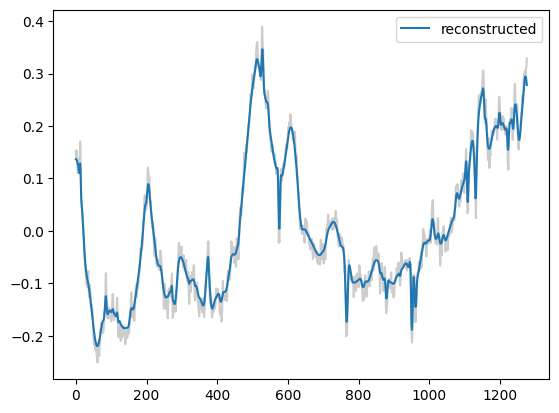

164


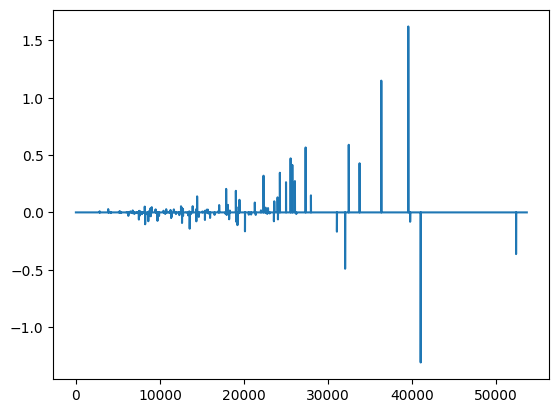

[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1740
44


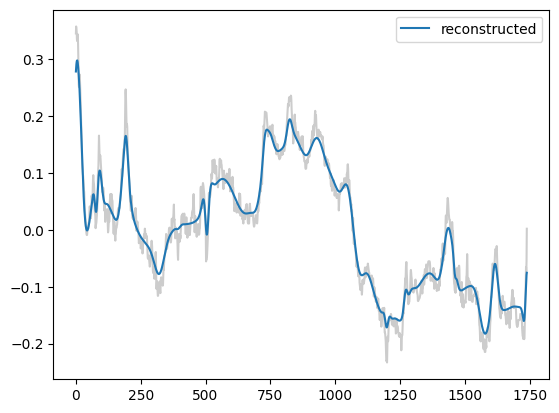

79


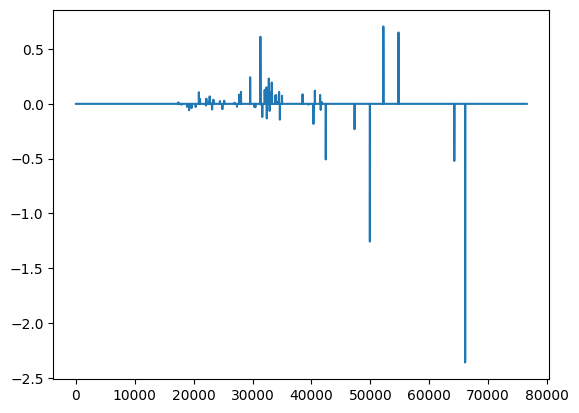

[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1485
43


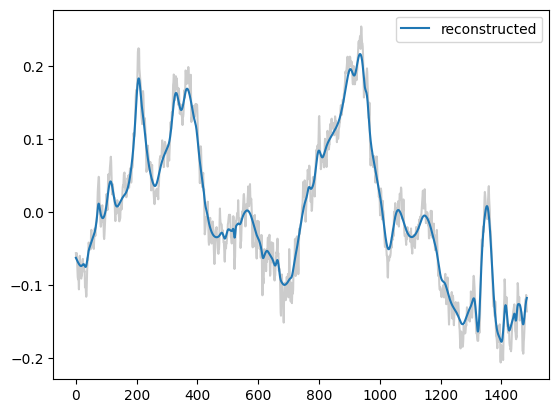

96


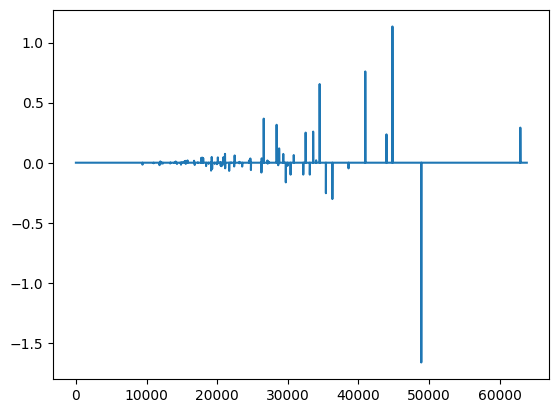

In [14]:

plts = []
coefs = []
for i in range(len(grey_array)):
    elt = np.asarray(np.asarray(grey_array[i]))
    elt -= np.mean(elt)
    print(np.sum(dictionary, axis=0))
    print(len(elt))
    coef, reconstructed = bpd.basis_pursuit_denoising(elt)
    
    ix = np.concatenate([np.zeros(len(coef)-len(coef)//8), np.ones(len(coef)//8)]).astype(bool)
    filtered_coef = np.where(ix, coef, 0)

    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(reconstructed, label="reconstructed")
    p = plt.legend()
    plt.show()
    
    print(np.count_nonzero(coef))
    plts.append(p)
    plt.figure()
    plt.plot(coef, label="Coefs")
    plt.show()
    coefs.append(coef)



[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1181
41


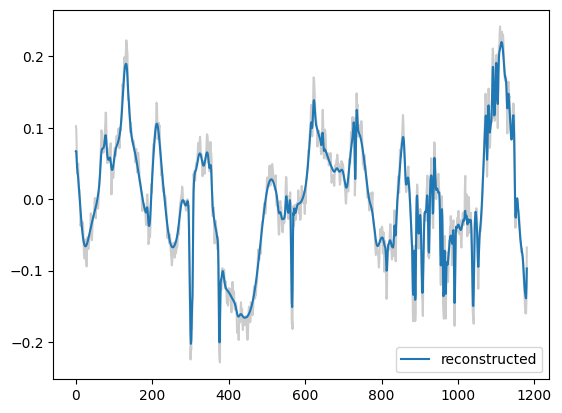

200


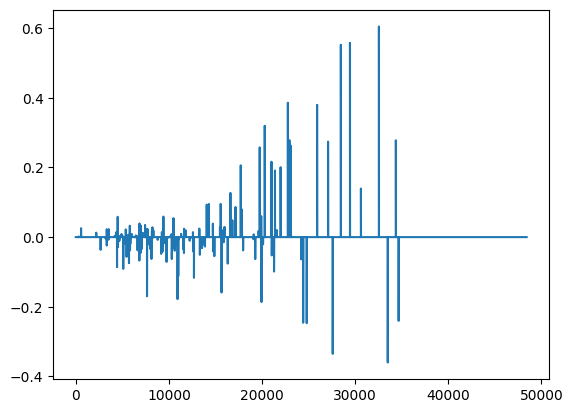

[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1277
42


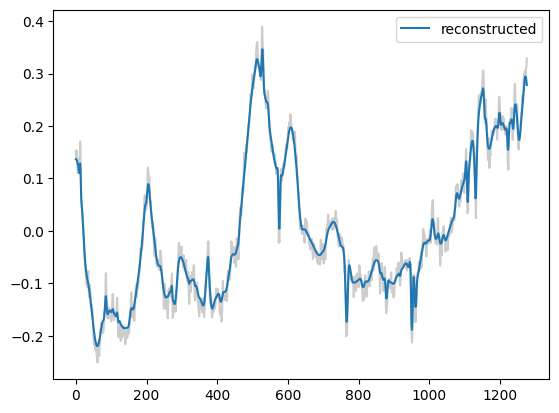

164


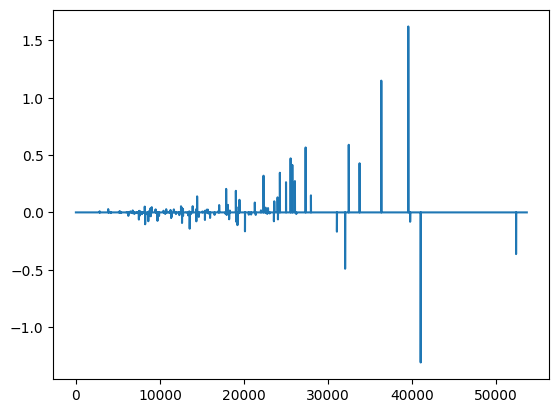

[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1740
44


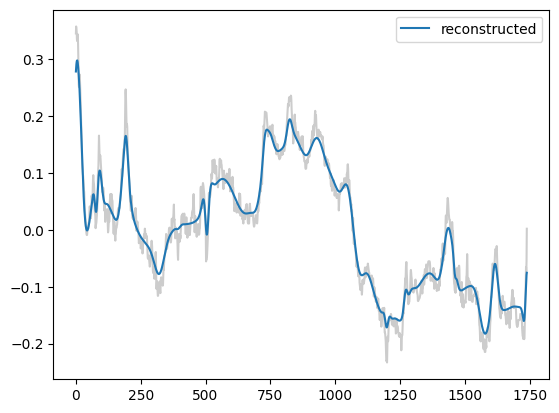

79


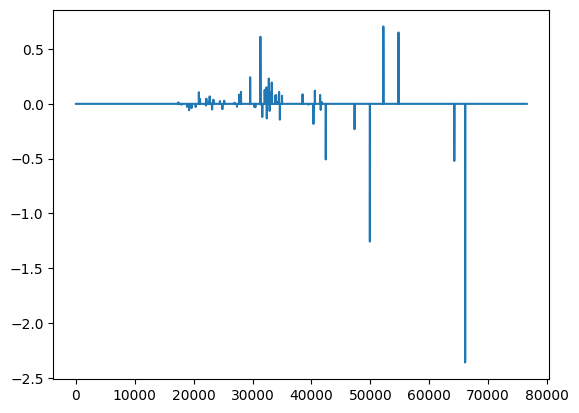

[ 2.82842712e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
1485
43


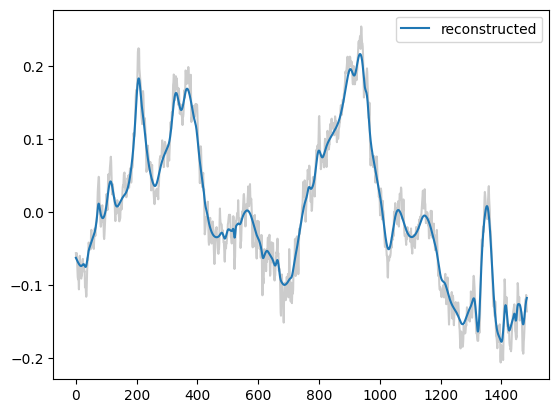

96


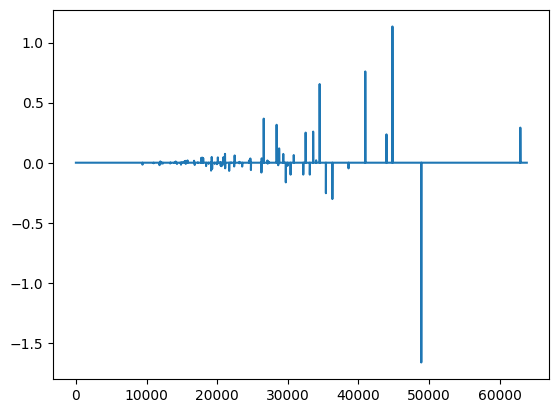

In [15]:

plts = []
coefs = []
for i in range(len(grey_array)):
    elt = np.asarray(np.asarray(grey_array[i]))
    elt -= np.mean(elt)
    print(np.sum(dictionary, axis=0))
    print(len(elt))
    coef, reconstructed = bpd.basis_pursuit_denoising(elt, None, prior, alpha=0.0001)
    
    ix = np.concatenate([np.zeros(len(coef)-len(coef)//8), np.ones(len(coef)//8)]).astype(bool)
    filtered_coef = np.where(ix, coef, 0)

    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(reconstructed, label="reconstructed")
    p = plt.legend()
    plt.show()
    
    print(np.count_nonzero(coef))
    plts.append(p)
    plt.figure()
    plt.plot(coef, label="Coefs")
    plt.show()
    coefs.append(coef)



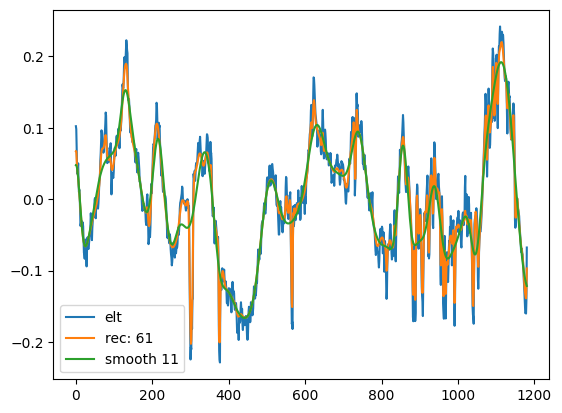

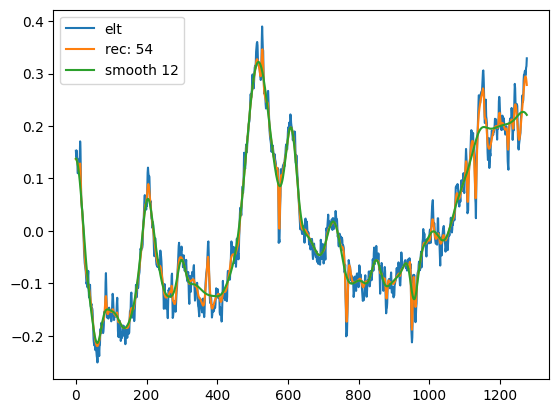

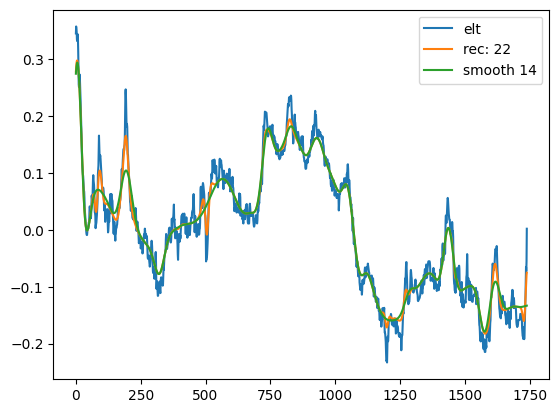

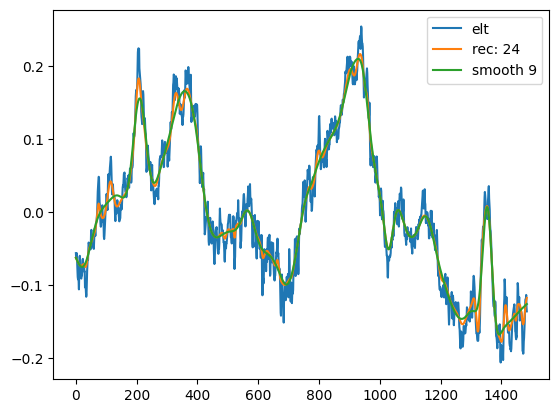

In [21]:
j = 0 
while j < len(coefs):
    coef = coefs[j]
    elt = np.asarray(np.asarray(grey_array[j]))

    scales = 2**np.arange(np.log2(len(elt)), step=0.25)
    dictionary = bpd.ricker_cwt_dictionary(len(elt), scales)

    nyears = len(elt)/scales

    ix = (nyears < 100)
    ix = np.repeat(ix, len(elt))
    
    rec = np.dot(dictionary, coef)
    smooth = np.dot(dictionary, np.multiply(coef, ix))

    plt.figure()
    plt.plot(elt, label="elt")
    rec_peaks = len(filt.find_peaks(rec))
    plt.plot(rec, label=f"rec: {rec_peaks}")
    smooth_peaks = len(filt.find_peaks(smooth))
    plt.plot(smooth, label=f"smooth {smooth_peaks}")
    plt.legend()
    plt.show()

    j += 1

<Figure size 640x480 with 0 Axes>

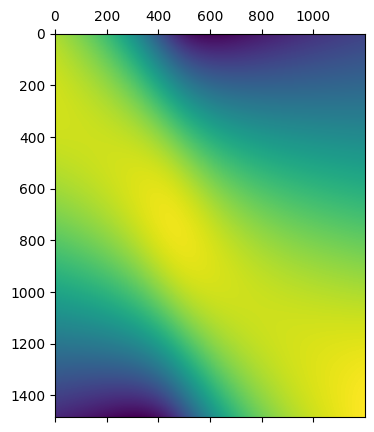

In [17]:
plt.figure()
plt.matshow(dictionary[:,-1200:])
plt.show()

36
34
37
38


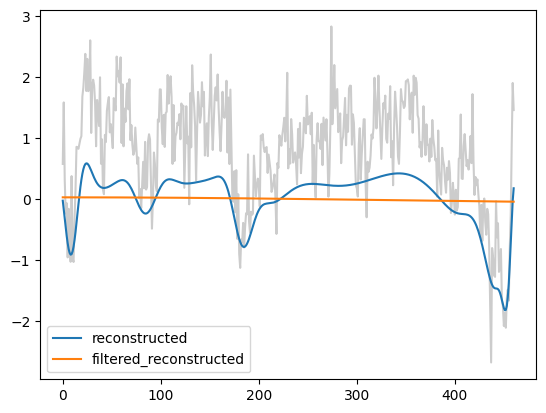

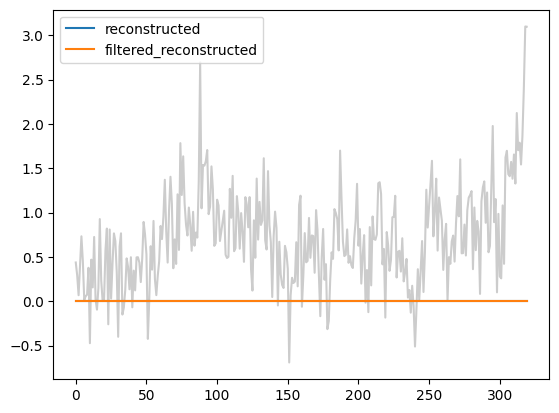

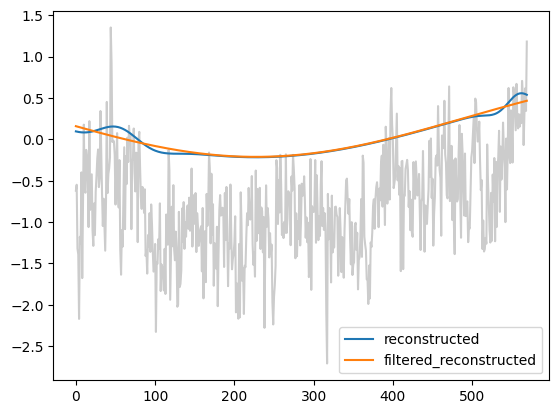

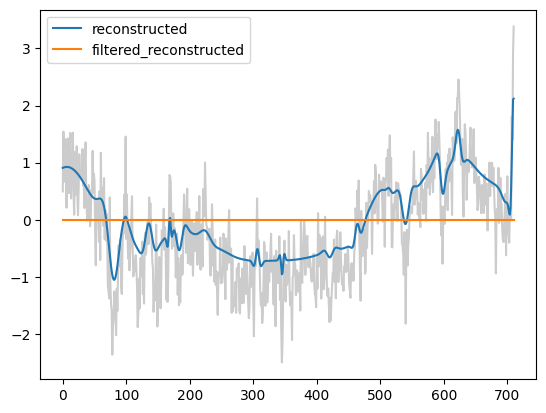

In [19]:
import basis_pursiut_denoising as bpd

plts = []
for i in range(len(elt_array)):
    elt = np.asarray(np.asarray(elt_array[i]))
    coef, reconstructed = bpd.basis_pursuit_denoising(elt, None, alpha=0.004)
    
    ix = np.concatenate([np.zeros(len(coef)-len(coef)//8), np.ones(len(coef)//8)]).astype(bool)
    filtered_coef = np.where(ix, coef, 0)
    dictionary = bpd.ricker_cwt_dictionary(len(elt), 2**np.arange(np.log2(len(elt)), step=0.25))
    filtered_reconstructed = np.dot(dictionary, filtered_coef)


    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(reconstructed, label="reconstructed")
    p = plt.plot(filtered_reconstructed, label="filtered_reconstructed")
    p = plt.legend()
    
    plts.append(p)



In [ ]:
dictionary = bpd.ricker_cwt_dictionary(len(elt), 2**np.arange(np.log2(len(elt)), step=0.5))

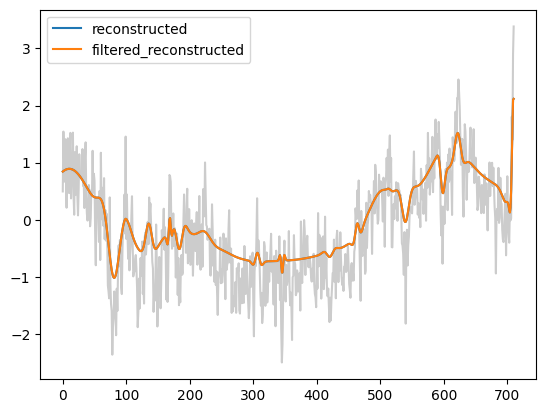

In [ ]:
r = 24
ix = np.concatenate([np.zeros(len(coef)//r), np.ones(len(coef)-len(coef)//r)]).astype(bool)
filtered_coef = np.where(ix, coef, 0)
filtered_reconstructed = np.dot(dictionary, filtered_coef)


p = plt.figure()
p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
p = plt.plot(reconstructed, label="reconstructed")
p = plt.plot(filtered_reconstructed, label="filtered_reconstructed")
p = plt.legend()

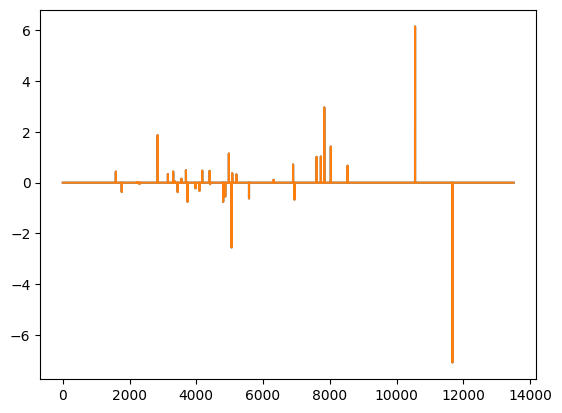

In [ ]:
plt.figure()
plt.plot(coef, label='Sparse Coefficients')
plt.plot(filtered_coef, label='Filtered Sparse Coefficients')
# plt.plot(np.abs(coef) > 0, label='Sparse Coefficients')
plt.show()

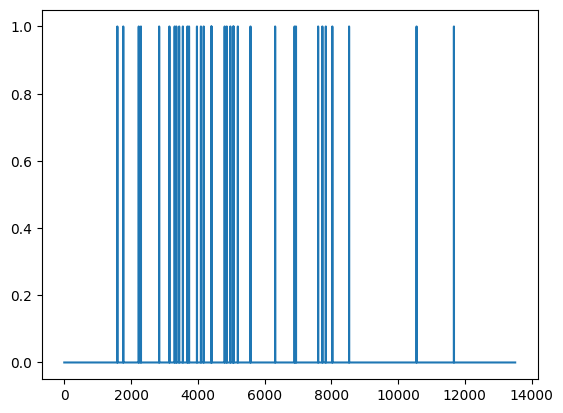

In [ ]:
plt.figure()
plt.plot(np.abs(filtered_coef)>0, label='Filtered Sparse Coefficients')
# plt.plot(np.abs(coef) > 0, label='Sparse Coefficients')
plt.show()

In [ ]:
fdict = dictionary[:,ix]
print(fdict[0])

[ 6.49864897e-10  6.49864897e-10  6.49864897e-10 ... -6.09482970e-02
 -6.08497623e-02 -6.07513728e-02]


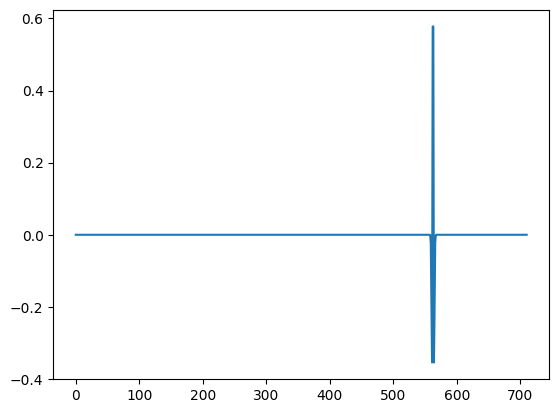

In [ ]:
plt.figure()
plt.plot(fdict[:,0])

<Figure size 640x480 with 0 Axes>

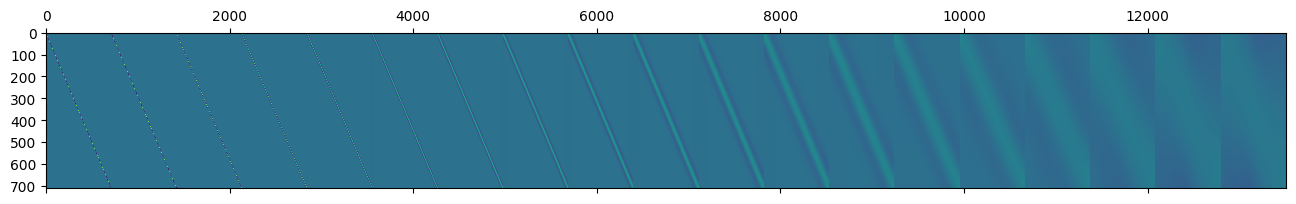

In [ ]:
plt.figure()
plt.matshow(dictionary, aspect='auto', cmap='viridis')
plt.show()

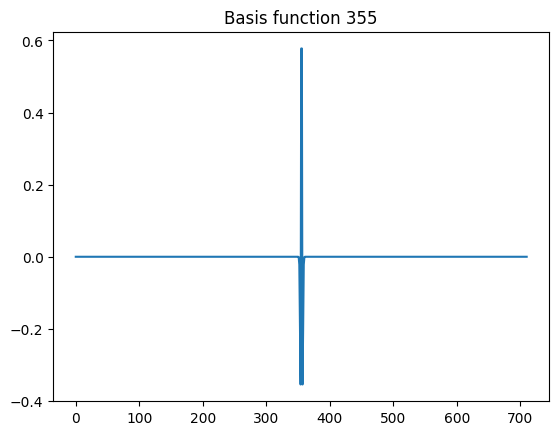

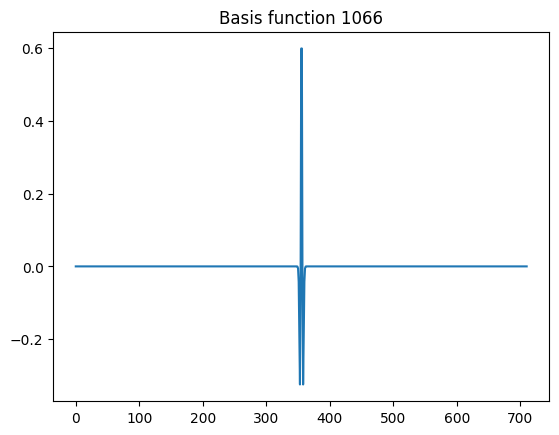

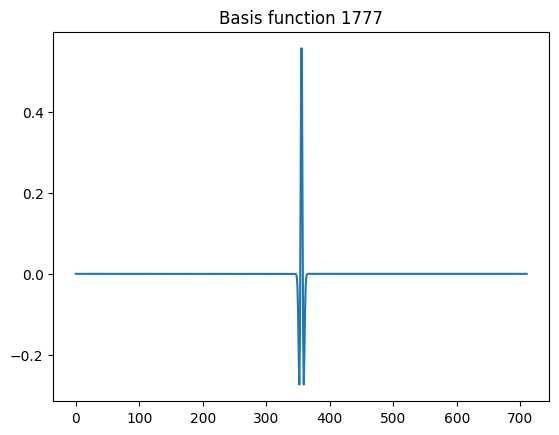

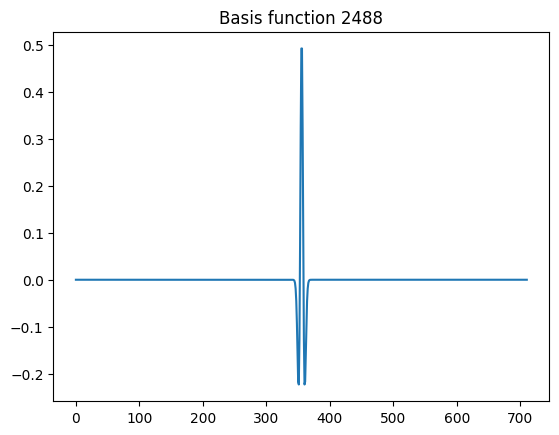

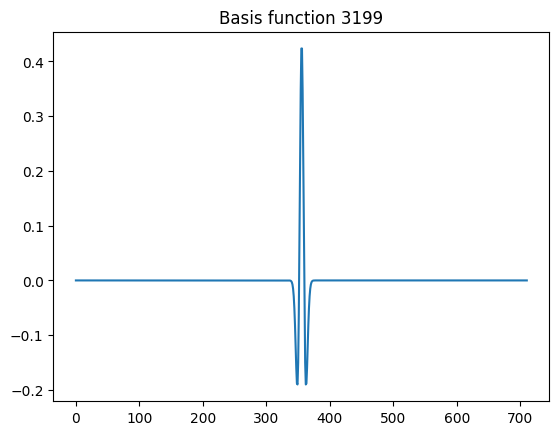

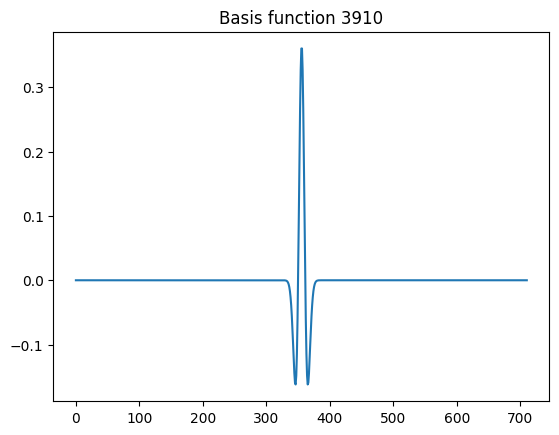

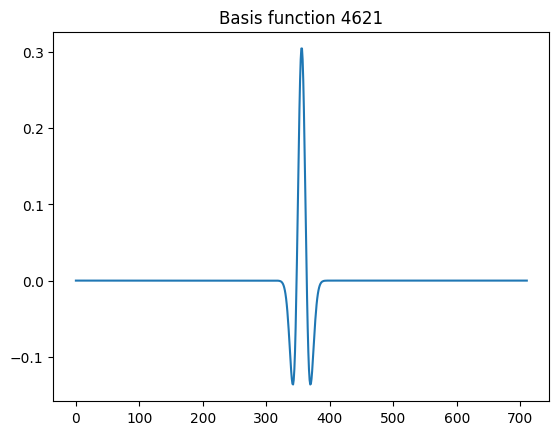

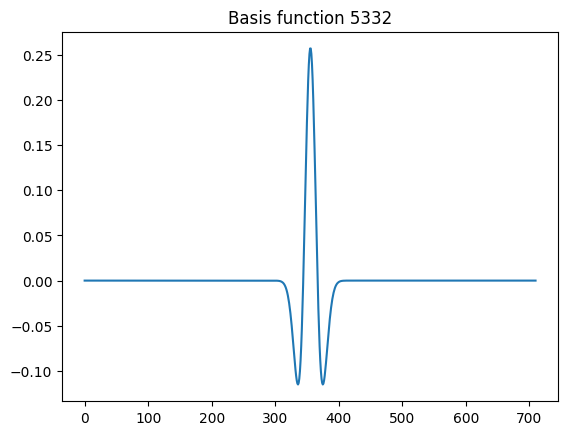

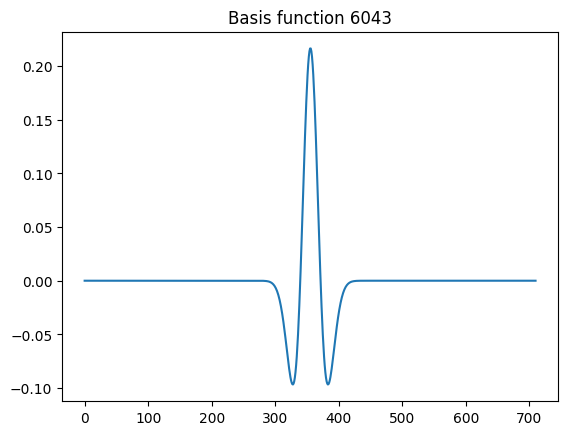

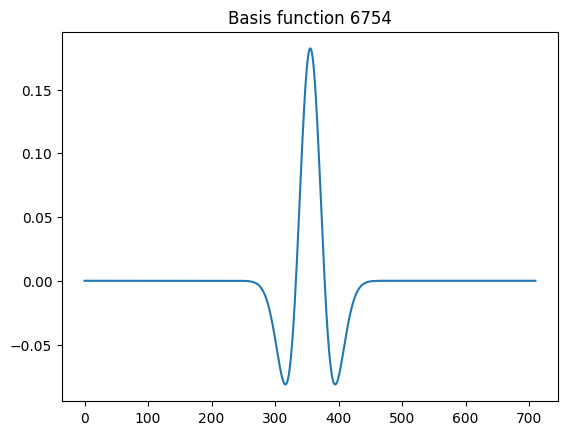

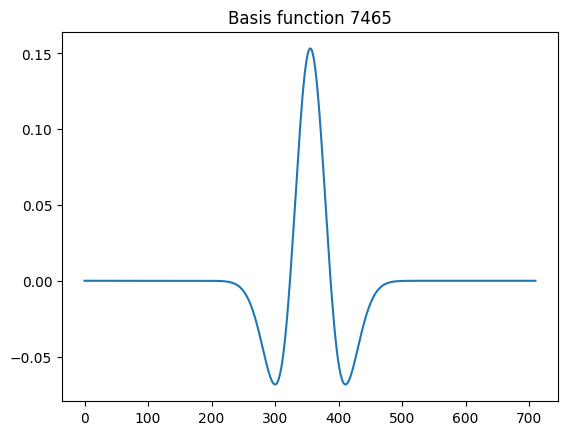

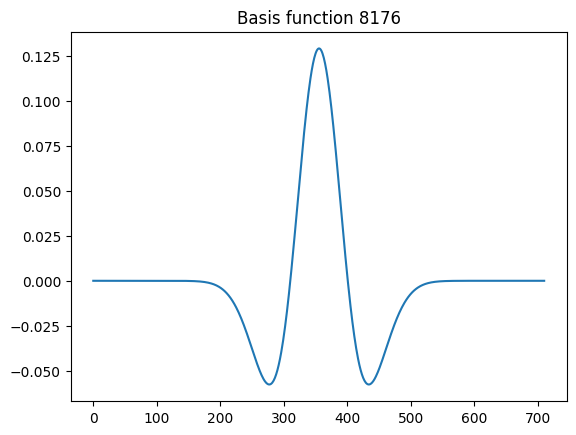

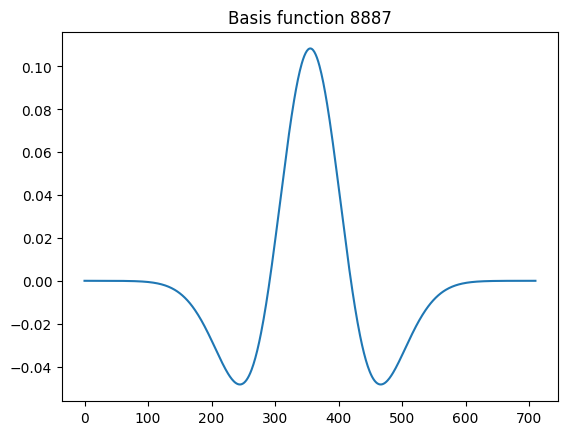

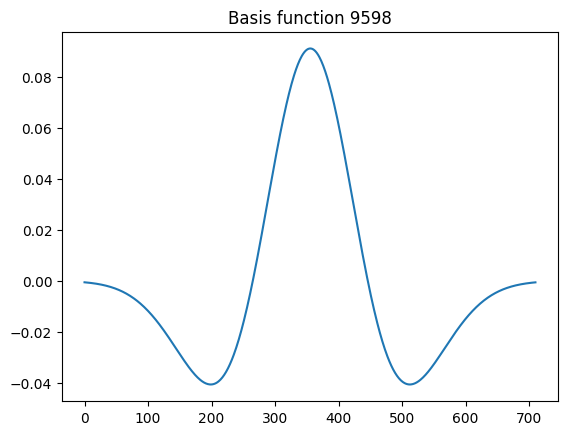

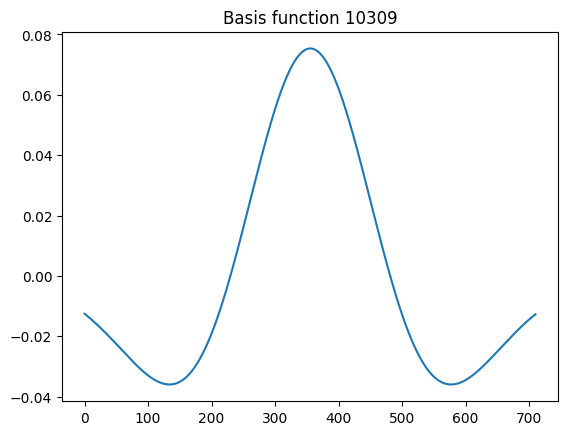

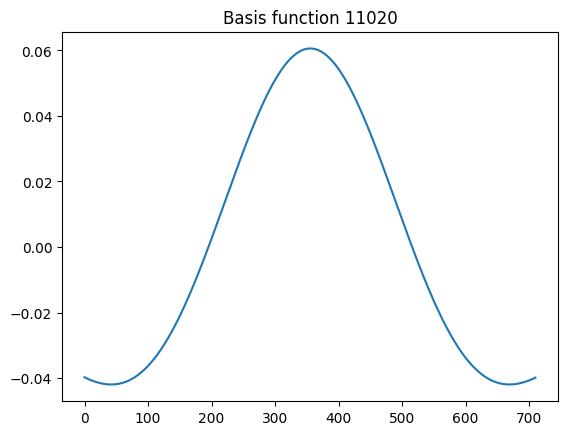

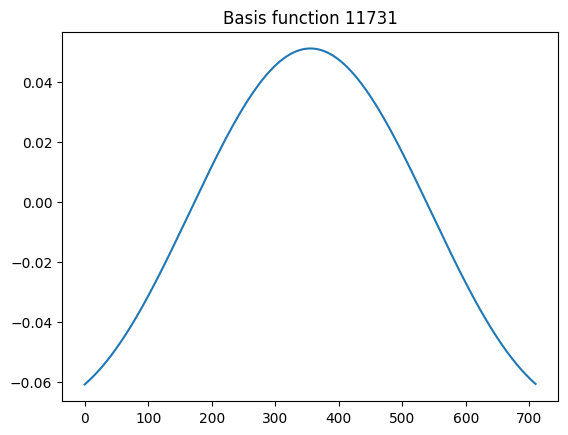

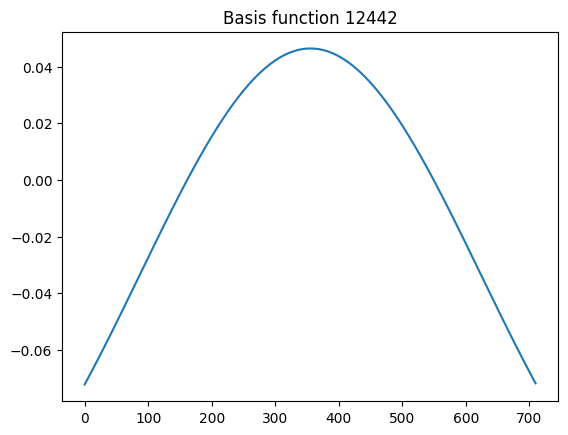

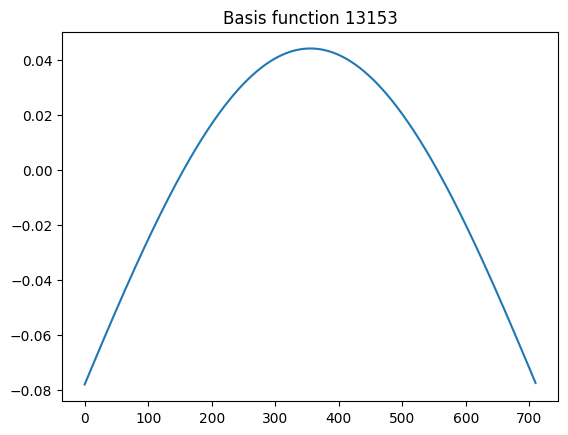

In [ ]:
i = 711//2
while i < dictionary.shape[1]:
    plt.figure()
    plt.plot(dictionary[:,i])
    plt.title(f"Basis function {i}")
    plt.show()
    i += 711
    